In [3]:
import numpy as np
from astropy.io import fits
from astropy import coordinates as coord
from astropy.modeling import models
from astropy import units as u
from astropy import wcs
import matplotlib.pyplot as plt

In [6]:
#from stwcs import updatewcs
#updatewcs.updatewcs('ib6o23rsq_flt.fits')

In [7]:
from astropy.utils.data import download_file
fn = download_file('https://github.com/npirzkal/aXe_WFC3_Cookbook/raw/main/cookbook_data/G141/ib6o23rsq_flt.fits', cache=True)
f = fits.open(fn)
f.info()

Filename: C:\Users\space\.astropy\cache\download\url\c9888fd91b7fb704dd07820a22b58fae\contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     265   ()      
  1  SCI           1 ImageHDU       140   (1014, 1014)   float32   
  2  ERR           1 ImageHDU        51   (1014, 1014)   float32   
  3  DQ            1 ImageHDU        43   (1014, 1014)   int16   
  4  SAMP          1 ImageHDU        37   (1014, 1014)   int16   
  5  TIME          1 ImageHDU        37   (1014, 1014)   float32   
  6  WCSCORR       1 BinTableHDU     59   7R x 24C   [40A, I, A, 24A, 24A, 24A, 24A, D, D, D, D, D, D, D, D, 24A, 24A, D, D, D, D, J, 40A, 128A]   


In [8]:
w=wcs.WCS(f[1].header)

In [9]:
acoef = dict(f[1].header['A*'])
a_order = acoef.pop('A_ORDER')
bcoef = dict(f[1].header['B_*'])
b_order = bcoef.pop('B_ORDER')
crpix = [f[1].header['CRPIX1'], f[1].header['CRPIX2']]

sip = models.SIP(np.array(crpix)-1, a_order=a_order, a_coeff=acoef, b_order=b_order, b_coeff=bcoef)

print('sip:', sip(1,1))
print('\nSIP computes the changes relative to (0,0), '
      'while astropy.wcs computes the sip correction relative to crpix. So we need to add '
      'CRPIX-1 (0-based) to the wcs solution in order to get what SIP computes.\n')
print('sip_wcs:', w.sip_pix2foc(1, 1,0) + np.array((506, 506)))
print('crpix :', crpix)

sip: (6.2214171815060615, 9.417176540566402)

SIP computes the changes relative to (0,0), while astropy.wcs computes the sip correction relative to crpix. So we need to add CRPIX-1 (0-based) to the wcs solution in order to get what SIP computes.

sip_wcs: [6.22141718 9.41717654]
crpix : [507.0, 507.0]


In [10]:
crval = [f[1].header['CRVAL1'], f[1].header['CRVAL2']]
cdmat = np.array([[f[1].header['CD1_1'], f[1].header['CD1_2']],
                  [f[1].header['CD2_1'], f[1].header['CD2_2']]])
cdmat

array([[ 3.61482227e-05,  9.42092248e-06],
       [ 1.04266331e-05, -3.22558210e-05]])

In [11]:
model = sip | models.Shift(-(crpix[0]-1)) & models.Shift(-(crpix[1]-1)) | \
        models.AffineTransformation2D(matrix=cdmat) | models.Pix2Sky_TAN() | \
        models.RotateNative2Celestial(crval[0], crval[1], 180)
sip(0,0)

(6.246247528628014, 9.45461343189367)

In [12]:
w.all_pix2world(1,1,0)

[array(53.04785953), array(-27.69643103)]

In [13]:
# This is the Linear WCS only, without distortion
print('crpix:', w.wcs_pix2world(crpix[0], crpix[1],1))
print('1,1: ', w.wcs_pix2world(1,1,1))

m = models.Shift(-crpix[0]) & models.Shift(-crpix[1]) | \
    models.AffineTransformation2D(matrix=cdmat) | models.Pix2Sky_TAN() | \
    models.RotateNative2Celestial(crval[0], crval[1], 180)
print('crpix:', m(crpix[0], crpix[1]))
print('1,1:', m(1,1))

crpix: [array(53.07349566), array(-27.70721824)]
1,1:  [array(53.04745393), array(-27.69617023)]
crpix: (53.07349565863769, -27.70721823660665)
1,1: (53.047453934124995, -27.69617023213373)


In [14]:
apcoef = {}
for key in acoef:
    apcoef['c' + key.split('A_')[1]] = acoef[key]
    
bpcoef = {}
for key in bcoef:
    bpcoef['c' + key.split('B_')[1]] = bcoef[key]
    
ap = models.Polynomial2D(a_order, **apcoef)
bp = models.Polynomial2D(b_order, **bpcoef)

In [15]:
# And with regular Polynomials instead of SIP
mp = models.Shift(-crpix[0]-1) & models.Shift(-crpix[1]-1) | \
     models.Mapping((0, 1, 0, 1)) | ap & bp | \
     models.AffineTransformation2D(matrix=cdmat) | models.Pix2Sky_TAN() |\
     models.RotateNative2Celestial(crval[0], crval[1], 180)
model(0, 0 )

(53.04780948313259, -27.69641013714909)

In [16]:
w.all_pix2world(1,1,0)

[array(53.04785953), array(-27.69643103)]

In [17]:
## Comparing with plots as Iva did

xx = np.arange(0,1014, 20)
yy = np.arange(0,1014, 20)

astropy_coords = w.pixel_to_world(xx, yy)
ra_sip, dec_sip = model(xx, yy)
ra_poly, dec_poly = mp(xx, yy)

In [18]:
ra_sip-ra_poly

array([-0.02604465, -0.02604453, -0.02604441, -0.02604429, -0.02604417,
       -0.02604405, -0.02604393, -0.02604381, -0.0260437 , -0.02604358,
       -0.02604346, -0.02604335, -0.02604323, -0.02604311, -0.026043  ,
       -0.02604289, -0.02604277, -0.02604266, -0.02604254, -0.02604243,
       -0.02604232, -0.02604221, -0.0260421 , -0.02604198, -0.02604187,
       -0.02604176, -0.02604165, -0.02604154, -0.02604143, -0.02604132,
       -0.02604121, -0.02604111, -0.026041  , -0.02604089, -0.02604078,
       -0.02604067, -0.02604057, -0.02604046, -0.02604035, -0.02604024,
       -0.02604014, -0.02604003, -0.02603992, -0.02603982, -0.02603971,
       -0.02603961, -0.0260395 , -0.02603939, -0.02603929, -0.02603918,
       -0.02603908])

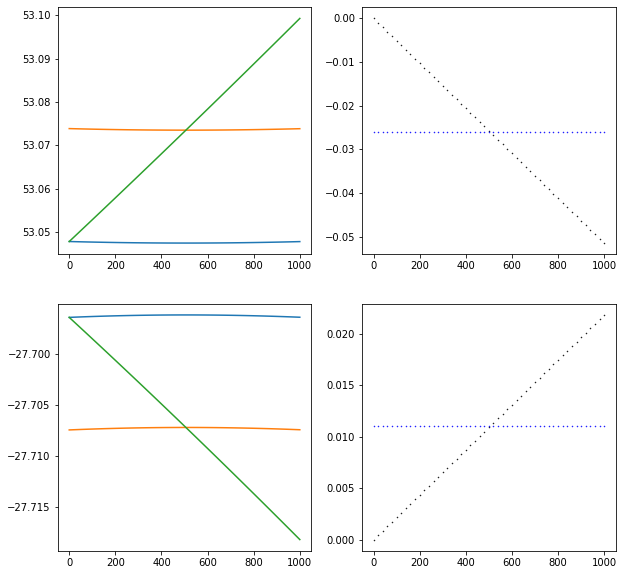

In [19]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].plot(xx, ra_sip)
axs[0,0].plot(xx, ra_poly)
axs[0,0].plot(xx, astropy_coords.ra.value)

axs[0,1].plot(xx, ra_sip-astropy_coords.ra.value, 'o', color='black', markersize=0.5)
axs[0,1].plot(xx, ra_sip-ra_poly, 'o', color='blue', markersize=0.5)

axs[1,0].plot(yy, dec_sip)
axs[1,0].plot(yy, dec_poly)
axs[1,0].plot(yy, astropy_coords.dec.value)

axs[1,1].plot(yy, dec_sip-astropy_coords.dec.value,  'o', color='black', markersize=0.5)
axs[1,1].plot(yy, dec_sip-dec_poly,  'o', color='blue', markersize=0.5)

In [20]:
m(xx, yy)

(array([53.04740247, 53.04843169, 53.04946091, 53.05049015, 53.05151939,
        53.05254864, 53.0535779 , 53.05460716, 53.05563644, 53.05666572,
        53.05769501, 53.05872431, 53.05975362, 53.06078293, 53.06181226,
        53.06284159, 53.06387093, 53.06490028, 53.06592963, 53.066959  ,
        53.06798837, 53.06901775, 53.07004714, 53.07107654, 53.07210595,
        53.07313536, 53.07416478, 53.07519422, 53.07622365, 53.0772531 ,
        53.07828256, 53.07931202, 53.08034149, 53.08137097, 53.08240046,
        53.08342996, 53.08445946, 53.08548898, 53.0865185 , 53.08754803,
        53.08857757, 53.08960711, 53.09063667, 53.09166623, 53.0926958 ,
        53.09372538, 53.09475497, 53.09578456, 53.09681417, 53.09784378,
        53.0988734 ]),
 array([-27.69614839, -27.69658517, -27.69702193, -27.69745869,
        -27.69789544, -27.69833218, -27.69876892, -27.69920564,
        -27.69964236, -27.70007907, -27.70051578, -27.70095248,
        -27.70138917, -27.70182585, -27.70226252, -27.7

In [21]:
print(model(507, 507))
print(m(507, 507))
print(mp(507, 507))
print(w.pixel_to_world(507,507))
print(w.all_pix2world(507, 507, 0))

(53.04745393550417, -27.696170233065562)
(53.07349565863769, -27.70721823660665)
(53.07349566001726, -27.70721823753826)
<SkyCoord (ICRS): (ra, dec) in deg
    (53.07354713, -27.70724007)>
[array(53.07354713), array(-27.70724007)]


In [22]:
f[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1014                                                  
NAXIS2  =                 1014                                                  
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ORIGIN  = 'HSTIO/CFITSIO March 2010'                                            
DATE    = '2016-09-14' / date this file was written (yyyy-mm-dd)                
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'ib6o23rsq        

In [23]:
ra_diff = ra_poly-astropy_coords.ra.value
ra_diff

array([ 0.02604465,  0.02501531,  0.02398596,  0.0229566 ,  0.02192724,
        0.02089787,  0.01986849,  0.01883911,  0.01780972,  0.01678032,
        0.01575091,  0.01472149,  0.01369207,  0.01266264,  0.0116332 ,
        0.01060376,  0.0095743 ,  0.00854484,  0.00751537,  0.00648589,
        0.00545641,  0.00442692,  0.00339742,  0.00236791,  0.00133839,
        0.00030886, -0.00072067, -0.00175021, -0.00277976, -0.00380932,
       -0.00483889, -0.00586846, -0.00689804, -0.00792764, -0.00895724,
       -0.00998685, -0.01101646, -0.01204609, -0.01307573, -0.01410537,
       -0.01513502, -0.01616468, -0.01719435, -0.01822403, -0.01925372,
       -0.02028342, -0.02131312, -0.02234284, -0.02337257, -0.0244023 ,
       -0.02543204])

In [24]:
ra_diff[1:] - ra_diff[:-1]

array([-0.00102934, -0.00102935, -0.00102936, -0.00102936, -0.00102937,
       -0.00102938, -0.00102939, -0.00102939, -0.0010294 , -0.00102941,
       -0.00102942, -0.00102942, -0.00102943, -0.00102944, -0.00102945,
       -0.00102945, -0.00102946, -0.00102947, -0.00102948, -0.00102948,
       -0.00102949, -0.0010295 , -0.00102951, -0.00102952, -0.00102953,
       -0.00102953, -0.00102954, -0.00102955, -0.00102956, -0.00102957,
       -0.00102958, -0.00102958, -0.00102959, -0.0010296 , -0.00102961,
       -0.00102962, -0.00102963, -0.00102964, -0.00102964, -0.00102965,
       -0.00102966, -0.00102967, -0.00102968, -0.00102969, -0.0010297 ,
       -0.00102971, -0.00102972, -0.00102972, -0.00102973, -0.00102974])

In [25]:
cdmat[0,0]*20 + cdmat[0,1]*20

0.0009113829043420336

In [26]:
cdmat[0,1]

9.42092247971798e-06

In [27]:
model

<CompoundModel(offset_1=-506., offset_2=-506., matrix_3=[[ 0.00003615,  0.00000942], [ 0.00001043, -0.00003226]], translation_3=[0., 0.], lon_5=53.07349566, lat_5=-27.70721824, lon_pole_5=180.)>

In [28]:
## Ricky's attempt at defining a model that matches the astropy WCS calculations

# Repeating coefficient retrievals here
acoef = dict(f[1].header['A*'])
a_order = acoef.pop('A_ORDER')
bcoef = dict(f[1].header['B_*'])
b_order = bcoef.pop('B_ORDER')
crpix = [f[1].header['CRPIX1'], f[1].header['CRPIX2']]

mr = (models.Shift(-(crpix[0]-1)) & models.Shift(-(crpix[1]-1)) | # Calculate u and v coords
     models.Mapping((0, 1, 0, 1, 0, 1)) | ap & bp & models.Identity(2) | # calculate f(u,v) and g(u,v)
     models.Mapping((0, 2, 1, 3)) | models.math.AddUfunc() & models.math.AddUfunc() | # Calculate u+f(u,v) and v+g(u,v)
     models.AffineTransformation2D(matrix=cdmat) | models.Pix2Sky_TAN() | 
     models.RotateNative2Celestial(crval[0], crval[1], 180)
     )
mr(0, 0)

(53.04780948313259, -27.69641013714909)

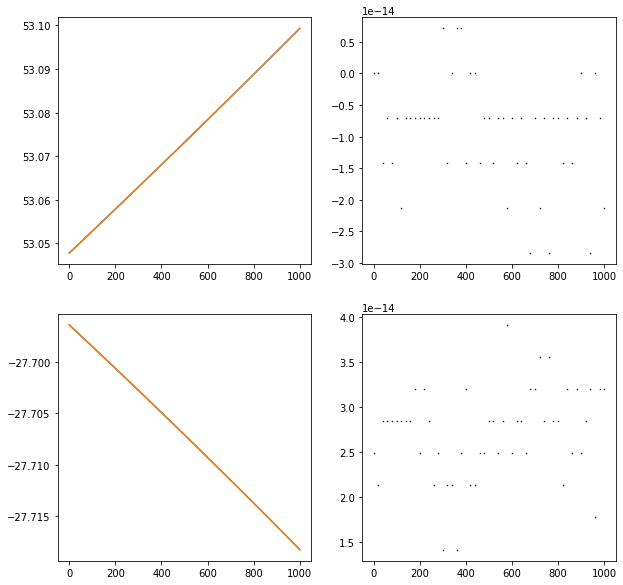

In [29]:
ra_r, dec_r = mr(xx, yy)

fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].plot(xx, ra_r)
axs[0,0].plot(xx, astropy_coords.ra.value)

axs[0,1].plot(xx, ra_r-astropy_coords.ra.value, 'o', color='black', markersize=0.5)

axs[1,0].plot(yy, dec_r)
axs[1,0].plot(yy, astropy_coords.dec.value)

axs[1,1].plot(yy, dec_r-astropy_coords.dec.value,  'o', color='black', markersize=0.5)